In [19]:
import pandas 
import pylab
from pandas import *
from pylab import *
import os

In [110]:
def readFileFlink(filename):
    return read_csv(filename,names = ["nan4","nan","passengerCnt", "num ele",
                                               "Latency","Time","nan2","nan3"])  
    
def readFileSpark(filename):
    return read_csv(filename,names = ["nan4","nan","passengerCnt", "num ele",
                                      "Latency","Time","nan2","nan3"])  

def getMeanLatency(file):
    lat=file.ix[1:len(file)-2,[4]]
    m=lat.mean()[0]
    return round(m,1)
def getSumElements(file):
    nums=file.ix[1:len(file)-2,[3]]
    return nums.sum()[0]
def getBatch(name):
    out=""
    for l in name:
        if(l=="-"):
            b=False
            return int(out)
        if(l=="c"):
            return 1000
        out+=str(l)
    return int(out)

def getTupleSpark(file,path):
    parts=path.split("\\")
    return (parts[1],int(parts[2]),int(parts[3]),int(parts[4]),int(getMeanLatency(file)),getSumElements(file),getBatch(parts[5]))
def getTupleFlink(file,path):
    parts=path.split("\\")
    return (parts[1],int(parts[2]),int(parts[3]),int(parts[4]),int(getMeanLatency(file)),getSumElements(file),0)
def mergeDuplicates(num,df):
    sys="system"
    win="windowSize"
    sli="slidingSize"
    wor="workload"
    lat="avg. latency"
    ele="num elements"
    bat="batchtime"
    end=0
    found=False
    #print(df.iloc[0][sys])
    if(num==len(df)-2):
        return df
    for i in range (num,len(df)-1):
        if( (df.iloc[i][sys]==df.iloc[i+1][sys]) and (df.iloc[i][win]==df.iloc[i+1][win]) ):
            if( (df.iloc[i][sli]==df.iloc[i+1][sli]) and (df.iloc[i][wor]==df.iloc[i+1][wor]) ):
                if( (df.iloc[i][bat]==df.iloc[i+1][bat]) ):
                    sums=(df.iloc[i][ele]+df.iloc[i+1][ele])
                    avg= (df.iloc[i][lat]*df.iloc[i][ele]+df.iloc[i+1][lat]*iloc[i+1][ele])/sums
                    df.set_value(i,lat,avg)
                    end=i
                    found=True
                    #df.index[i][lat]=avg
                    #df.index[i][ele]=sums
                    break;
                    #df=df.drop(df.index[[i+1]])
                    #print(avg,sums)
                    #print("------")
        #print(df[1])
     
    
    if (found):
        return mergeDuplicates( end,df.drop(df.index[[end+1]]) )
    else:
        return df
#df=getResults()
#df=mergeDuplicates(0,df)

#df
#df.drop(df.index[[1,3]])
#df[0:10]
#iris.drop(iris.index[[1,3,5,7]])

,system,windowSize,slidingSize,workload,avg. latency,num elements,batchtime
0,flink,1000.0,1000.0,100000.0,25.0,714211.0,0.0
1,flink,1000.0,1000.0,1000000.0,14.0,2423327.0,0.0
2,flink,1000.0,1000.0,500000.0,27.0,4225028.0,0.0
4,flink,10000.0,1000.0,100000.0,92.0,115491880.0,0.0
5,flink,11000.0,1000.0,100000.0,13.0,55464198.0,0.0
6,flink,13000.0,1000.0,100000.0,16.0,54843576.0,0.0
7,flink,15000.0,1000.0,100000.0,80.0,118224141.0,0.0
8,flink,2000.0,1000.0,100000.0,21.0,10964010.0,0.0
9,flink,2000.0,1000.0,500000.0,21.0,7341759.0,0.0
10,flink,20000.0,1000.0,100000.0,8.0,97551945.0,0.0


In [72]:
#find all results
import glob, os
#os.chdir("/results")
def getResults():
    
    flink=True
    data=list()
    #df = DataFrame(data,columns=index)   
    index=["system","windowSize","slidingSize","workload","avg. latency","num elements","batchtime"]



    for sysDir in glob.glob("results\*"):
        if (sysDir=="results\spark"):
            flink=False
        else:
            flink=True
        for windowTime in glob.glob(sysDir+"\*"):
            for slidingTime in glob.glob(windowTime+"\*"):
                for workload in glob.glob(slidingTime+"\*"):
                    for files in glob.glob(workload+"\*"):
                        found=False
                        if(flink):
                            if (os.path.getsize(files)>0):
                                file=readFileFlink(files)
                                t=getTupleFlink(file,files)
                                found=True
                                #print(file,"/n",files)
                        else:
                             if (os.path.getsize(files)>0):
                                file=readFileSpark(files)
                                t=getTupleSpark(file,files)
                                found=True
                        if(found):      
                            data.append(t)
    df = DataFrame(data,columns=index)                        
    df.append(Series(t[0:7],index=index),ignore_index=True) 
    return df
df=getResults()
#df
#resS=df.loc[df["system"]=="flink"].loc[df["windowSize"]==3000].loc[df["slidingSize"]==2000]
#resS


,system,windowSize,slidingSize,workload,avg. latency,num elements,batchtime
0,flink,1000,1000,100000,25,714211,0
1,flink,1000,1000,1000000,14,2423327,0
2,flink,1000,1000,500000,12,4225028,0
3,flink,1000,1000,500000,42,285965,0
4,flink,10000,1000,100000,92,115491880,0
5,flink,11000,1000,100000,13,55464198,0
6,flink,13000,1000,100000,16,54843576,0
7,flink,15000,1000,100000,80,118224141,0
8,flink,2000,1000,100000,21,10964010,0
9,flink,2000,1000,500000,21,7341759,0


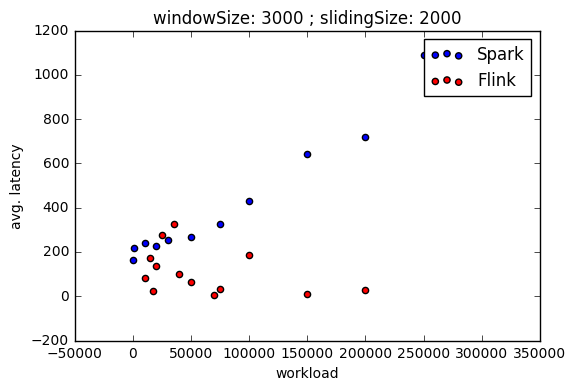

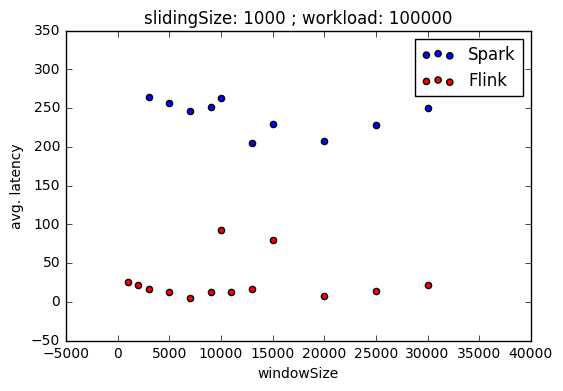

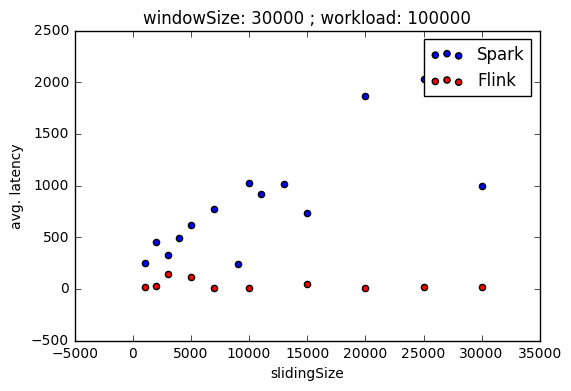

In [116]:
#analysis
import matplotlib.pyplot as plt
%matplotlib inline
def plotLatency(varName2,var2,varName3,var3,xName,yName):
    
    resS=df.loc[df["system"]=="spark"].loc[df[varName2]==var2].loc[df[varName3]==var3]
    resF=df.loc[df["system"]=="flink"].loc[df[varName2]==var2].loc[df[varName3]==var3]
    titleString=varName2+": "+str(var2)+" ; "+varName3+": "+str(var3)
    ax=resS.plot.scatter(x=xName,y=yName,label="Spark",color="Blue")
    resF.plot.scatter(x=xName,y=yName,label="Flink",ax=ax,color="Red",title=titleString)
    #resS.plot(x=xName,y=yName,title=titleString,kind="scatter" )
    #resF.plot(x=xName,y=yName,title=titleString )
    #reg = ols(y=resS[yName], x=resS[xName])
    #print(reg.summary)
    path='graphs/%s%s%s%s.png' %(varName2,var2,varName3,var3)
    #savefig(path)
sys="system"
win="windowSize"
sli="slidingSize"
wor="workload"
lat="avg. latency"
ele="num elements"
df=getResults()
df=mergeDuplicates(0,df)
plotLatency(win,3000,sli,2000,wor,lat)

plotLatency(sli,1000,wor,100000,win,lat)

plotLatency(win,30000,wor,100000,sli,lat)
#res.ix[:,[4]].plot(kind="line",x=["da","hhh"],y="latency in seconds")
#res
#savefig('graphs/figure1.pdf')